## Homogeneous ice nucleation in an ab initio machine learning model of water
### Pablo M. Piaggi, Jack Weis, Athanassios Z. Panagiotopoulos, Pablo G. Debenedetti, and Roberto Car

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import splrep,splev

In [2]:
font = {'family' : 'serif',
        'serif'   : 'palatino',
        #'sans-serif'    : 'Computer Modern Sans serif',
        'style'   : 'normal',
        'variant'   : 'normal',
        'stretch'   : 'normal',
        'weight'   : 'normal',
        'size'   : 30}
plt.rc('font', **font)
plt.rc('text', usetex=True)
plt.rcParams['figure.figsize'] = (14,8) # The unit here is inches. 3.5 is good for one column, 7 is good for whole page

In [3]:
colors=plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
def batch(data,total_batch_num,batch_num):
    """Make batches or blocks.

    Args:
        data (numpy array): Data
        total_batch_num (int): Total desired number of batches (blocks)
        batch_num (int): Number of the batch that will be returned

    Returns:
        numpy array: The selected batch of the data array
    """
    if (batch_num<0):
        raise Exception('batch_num must be greater than 0! Start from index 0')
    if (batch_num>(total_batch_num-1)):
        raise Exception('batch_num must be smaller than total_batch_num-1!')
    batch_size=int(data.shape[0]/total_batch_num)
    start=batch_size*batch_num
    end=batch_size*(batch_num+1)
    if (end>data.shape[0] or batch_num==(total_batch_num-1)):
        end=data.shape[0]
    return data[start:end]

def averageBatch(values,weights,total_batch_num):
    """Find the weighted average of some quantity in batches

    Args:
        values (numpy array): Data to be averages
        weights (numpy array): Weights
        total_batch_num (int): Total desired number of batches (blocks)

    Returns:
        numpy array: The weighted average of the data in each batch (block)
        numpy array: The weights of each batch (block)

    """
    valuesVector=np.zeros([total_batch_num])
    Z=np.zeros([total_batch_num])
    for k in range(total_batch_num):
        valuesVector[k]=np.average(batch(values,total_batch_num,k),weights=batch(weights,total_batch_num,k))
        Z[k]=np.sum(batch(weights,total_batch_num,k))
    return valuesVector, Z

def observableAvgBatch(observable,bias,temperature,total_batch_num):
    """Find the average in blocks of some observable that was sampled in a biased simulation.

    Args:
        observable (numpy array): Observable
        bias (numpy array): Bias potential in kJ/mol
        temperature (float): Temperature in K
        total_batch_num (int): Total desired number of batches (blocks)

    Returns:
        numpy array: The average of the observable in each batch (block)
        numpy array: The weights of each batch (block)

    """
    beta=1./(0.00831441001626*temperature)
    return averageBatch(observable,np.exp(beta*bias),total_batch_num)

def stdWithWeights(values, weights):
    """Calculate a standard deviation of observations with weights.

    Args:
        values (numpy array): Data
        weights (numpy array): Weights

    Returns:
        float: Standard deviation
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise calculation of variance
    variance = np.average((values-average)**2, weights=weights)
    # Number of samples based on effective sample size
    N=np.power(np.sum(weights),2) / np.sum(np.power(weights,2))
    return np.sqrt(variance*N/(N-1))

def stdOfMeanWithWeights(values, weights):
    """Calculate a standard deviation of observations with weights.

    Args:
        values (numpy array): Data
        weights (numpy array): Weights

    Returns:
        float: Standard deviation
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    N=np.power(np.sum(weights),2) / np.sum(np.power(weights,2)) #float(values.shape[0])
    return np.sqrt(variance/(N-1))

def averageObservableWithError(obs,condition,temperature,bias,numBatches):
    beta=1./(0.00831441001626*temperature) # 1/(kJ/mol)
    logweights=beta*bias
    logweights -= np.amax(logweights)
    weights=np.exp(logweights)
    obsAvgBatches, Z = averageBatch(obs[condition],weights[condition],numBatches)
    obsAvg=np.average(obsAvgBatches, weights=Z)
    error = stdOfMeanWithWeights(obsAvgBatches, Z)
    return obsAvg, error

    
def freeEnergyWithErrorCondition(bias,temperature,condition1,condition2,numBatches):
    beta=1./(0.00831441001626*temperature) # 1/(kJ/mol)
    logweights=beta*bias
    logweights -= np.amax(logweights)
    probSolid=np.sum(np.exp(logweights[condition1]))
    probLiquid=np.sum(np.exp(logweights[condition2]))
    freeEnergy=-(1./beta)*np.log(probSolid/probLiquid)
    obs1=np.zeros(bias.shape[0])
    obs1[condition1]=1.0
    obsAvgBatches1, Z1 = averageBatch(obs1,np.exp(logweights),numBatches)
    obsAvg1=np.average(obsAvgBatches1, weights=Z1)
    errorObs1 = stdOfMeanWithWeights(obsAvgBatches1, Z1)
    obs2=np.zeros(bias.shape[0])
    obs2[condition2]=1.0
    obsAvgBatches2, Z2 = averageBatch(obs2,np.exp(logweights),numBatches)
    obsAvg2=np.average(obsAvgBatches2, weights=Z2)
    errorObs2 = stdOfMeanWithWeights(obsAvgBatches2, Z2)
    errorFreeEnergy = (1./beta)*(np.power(errorObs1/obsAvg1,2)+np.power(errorObs2/obsAvg2,2))
    return freeEnergy, errorFreeEnergy


## pI

In [5]:
ignore=1*1000
COLVAR=np.genfromtxt("Prismatic/COLVAR.0")[:-1,:]
final=COLVAR.shape[0]
print(final)
COLVAR = np.empty((4*(final-ignore),COLVAR.shape[1]))
COLVAR[0::4,:] = np.genfromtxt("Prismatic/COLVAR.0")[ignore:final,:]
COLVAR[1::4,:] = np.genfromtxt("Prismatic/COLVAR.1")[ignore:final,:]
COLVAR[2::4,:] = np.genfromtxt("Prismatic/COLVAR.2")[ignore:final,:]
COLVAR[3::4,:] = np.genfromtxt("Prismatic/COLVAR.3")[ignore:final,:]

195917


In [6]:
bias=np.copy(COLVAR[:,9]) +np.copy(COLVAR[:,17])+np.copy(COLVAR[:,19])+np.copy(COLVAR[:,22])
threshold=50
threshold2=300
choose=np.logical_and(np.logical_and(COLVAR[:,17]<threshold,COLVAR[:,19]<threshold),np.logical_and(COLVAR[:,9]<threshold2,COLVAR[:,22]<threshold))
cv1=np.copy(COLVAR[choose,4])
cv2=np.copy(COLVAR[choose,2])
cv3=np.copy(COLVAR[choose,6])
cv4=np.copy(COLVAR[choose,25])
cv5=np.copy(COLVAR[choose,27])
ene=np.copy(COLVAR[choose,7])
vol1=np.copy(COLVAR[choose,8])
bias=np.copy(COLVAR[choose,9]) +np.copy(COLVAR[choose,17])+np.copy(COLVAR[choose,19])+np.copy(COLVAR[choose,22])
print(bias.shape)

(770973,)


<ipython-input-7-c62d0be37f8d>:25: RuntimeWarning: divide by zero encountered in log
  fes = -(1./beta)*np.log(H)


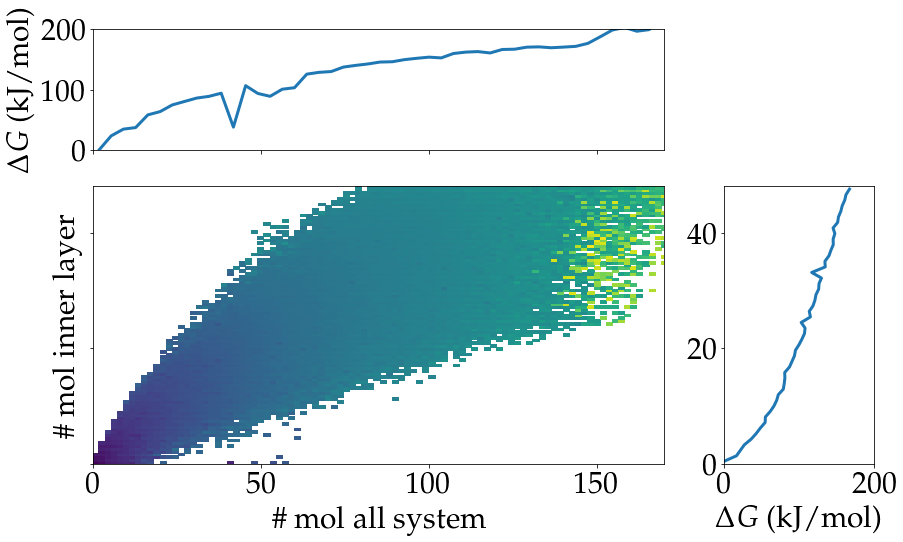

In [7]:
font = {'family' : 'serif',
        'serif'   : 'palatino',
        #'sans-serif'    : 'Computer Modern Sans serif',
        'style'   : 'normal',
        'variant'   : 'normal',
        'stretch'   : 'normal',
        'weight'   : 'normal',
        'size'   : 30}
plt.rc('font', **font)
plt.rc('text', usetex=True)
plt.rcParams['figure.figsize'] = (14,8) # The unit here is inches. 3.5 is good for one column, 7 is good for whole page


grid = plt.GridSpec(3, 4, wspace=0.4, hspace=0.3)
ax1 = plt.subplot(grid[0, :-1])
ax2 = plt.subplot(grid[1:, -1])
ax3 = plt.subplot(grid[1:, :-1])

temperature=312
beta=1./(0.00831441001626*temperature) # 1/(kJ/mol)
logweights=beta*bias
logweights -= np.amax(logweights)
H, xedges, yedges = np.histogram2d(cv4, cv5, bins=(100,100), density=True, weights=np.exp(logweights) )
H = H.T
fes = -(1./beta)*np.log(H)
X, Y = np.meshgrid(xedges, yedges)
cm = ax3.pcolormesh(X, Y, fes)
#plt.colorbar(cm, cax=ax4, orientation="horizontal", pad=0.5)

ax3.set_xlim([0,170])
ax3.set_ylim([0,48])
ax3.set_yticklabels([])
ax3.set_xlabel("\# mol all system")
ax3.set_ylabel("\# mol inner layer")

hist, bin_edges = np.histogram(cv4, weights=np.exp(logweights), density=True, bins=50) #,bins=65,range=(0,130))
freeEnergy=-(1./beta)*np.log(hist)
freeEnergy -= np.amin(freeEnergy[:5])
binCenters=(bin_edges[:-1]+bin_edges[1:])/2
ax1.plot(binCenters,freeEnergy,linewidth=3)
ax1.set_xlim([0,170])
ax1.set_ylim([0,200])
ax1.set_xticklabels([])
ax1.set_ylabel("$\Delta G$ (kJ/mol)")


hist, bin_edges = np.histogram(cv5, weights=np.exp(logweights), density=True, bins=50) #,bins=65,range=(0,130))
freeEnergy=-(1./beta)*np.log(hist)
freeEnergy -= np.amin(freeEnergy[:5])
binCenters=(bin_edges[:-1]+bin_edges[1:])/2
ax2.plot(freeEnergy,binCenters,linewidth=3)
ax2.set_ylim([0,48])
ax2.set_xlim([0,200])
ax2.set_xlabel("$\Delta G$ (kJ/mol)")

plt.show()

In [8]:
temperature=312
condition1=cv5 < 47.5
condition2=cv5 > 47.5
numBatches=4
deltaF, deltaFerror = freeEnergyWithErrorCondition(bias,temperature,condition1,condition2,numBatches)
print("Delta F",deltaF,"error",deltaFerror)
area=17.8506*21.9326
from_kJmol_to_Jm2=6.02214076/1000
num_surfaces=2
gamma=np.abs(deltaF)/(from_kJmol_to_Jm2*area*num_surfaces)
gamma_min=(np.abs(deltaF)-np.abs(deltaFerror))/(from_kJmol_to_Jm2*area*num_surfaces)
gamma_max=(np.abs(deltaF)+np.abs(deltaFerror))/(from_kJmol_to_Jm2*area*num_surfaces)
print("Interfacial free energy",gamma,"min",gamma_min,"max",gamma_max)

Delta F -167.96773324166597 error 0.24930444815417518
Interfacial free energy 35.6206653108416 min 35.56779569036856 max 35.67353493131464


## pB

In [9]:
ignore=1*1000
COLVAR=np.genfromtxt("Basal/COLVAR.0")[:-1,:]
final=COLVAR.shape[0]
print(final)
COLVAR = np.empty((4*(final-ignore),COLVAR.shape[1]))
COLVAR[0::4,:] = np.genfromtxt("Basal/COLVAR.0")[ignore:final,:]
COLVAR[1::4,:] = np.genfromtxt("Basal/COLVAR.1")[ignore:final,:]
COLVAR[2::4,:] = np.genfromtxt("Basal/COLVAR.2")[ignore:final,:]
COLVAR[3::4,:] = np.genfromtxt("Basal/COLVAR.3")[ignore:final,:]

142491


In [10]:
bias=np.copy(COLVAR[:,9]) +np.copy(COLVAR[:,17])+np.copy(COLVAR[:,19])+np.copy(COLVAR[:,22])
threshold=10
threshold2=250
choose=np.logical_and(np.logical_and(COLVAR[:,17]<threshold,COLVAR[:,19]<threshold),np.logical_and(COLVAR[:,9]<threshold2,COLVAR[:,22]<threshold))
time=np.copy(COLVAR[choose,0])
cv1=np.copy(COLVAR[choose,4])
cv2=np.copy(COLVAR[choose,2])
cv3=np.copy(COLVAR[choose,6])
cv4=np.copy(COLVAR[choose,25])
cv5=np.copy(COLVAR[choose,27])
ene=np.copy(COLVAR[choose,7])
vol1=np.copy(COLVAR[choose,8])
bias=np.copy(COLVAR[choose,9]) +np.copy(COLVAR[choose,17])+np.copy(COLVAR[choose,19])+np.copy(COLVAR[choose,22])
print(bias.shape)

(534481,)


In [11]:
COLVAR0 = np.genfromtxt("Basal/COLVAR.0")
COLVAR1 = np.genfromtxt("Basal/COLVAR.1")
COLVAR2 = np.genfromtxt("Basal/COLVAR.2")
COLVAR3 = np.genfromtxt("Basal/COLVAR.3")

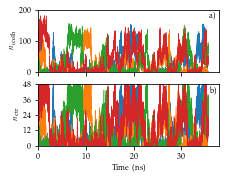

In [12]:
font = {'family' : 'serif',
        'serif'   : 'palatino',
        #'sans-serif'    : 'Computer Modern Sans serif',
        'style'   : 'normal',
        'variant'   : 'normal',
        'stretch'   : 'normal',
        'weight'   : 'normal',
        'size'   : 8}
plt.rc('font', **font)
plt.rc('text', usetex=True)
plt.rcParams['figure.figsize'] = (3.25, 2.5) # The unit here is inches. 3.5 is good for one column, 7 is good for whole page

fig, ax = plt.subplots(2,sharex=True)

mytime = COLVAR0[:,0]
mycv = COLVAR0[:,25]
ax[0].plot(mytime/1000,mycv,linewidth=0.5)
mytime = COLVAR1[:,0]
mycv = COLVAR1[:,25]
ax[0].plot(mytime/1000,mycv,linewidth=0.5)
mytime = COLVAR2[:,0]
mycv = COLVAR2[:,25]
ax[0].plot(mytime/1000,mycv,linewidth=0.5)
mytime = COLVAR3[:,0]
mycv = COLVAR3[:,25]
ax[0].plot(mytime/1000,mycv,linewidth=0.5)

ax[0].set_ylim([0,200])
ax[0].set_ylabel(r'$n_{\mathrm{ice \: Ih}}$')
ax[0].text(36.5,180,"a)",ha='center',va='center')

mytime = COLVAR0[:,0]
mycv = COLVAR0[:,27]
ax[1].plot(mytime/1000,mycv,linewidth=0.5)
mytime = COLVAR1[:,0]
mycv = COLVAR1[:,27]
ax[1].plot(mytime/1000,mycv,linewidth=0.5)
mytime = COLVAR2[:,0]
mycv = COLVAR2[:,27]
ax[1].plot(mytime/1000,mycv,linewidth=0.5)
mytime = COLVAR3[:,0]
mycv = COLVAR3[:,27]
ax[1].plot(mytime/1000,mycv,linewidth=0.5)

ax[1].set_ylim([0,48])
ax[1].set_yticks([0,12,24,36,48])
ax[1].set_xlim([0,38])
ax[1].set_xlabel("Time (ns)")
ax[1].set_ylabel(r"$n_{\mathrm{ctr}}$")
ax[1].text(36.5,42,"b)",ha='center',va='center')

#plt.savefig("ice_mol.png",dpi=300,bbox_inches='tight')  # publication quality

plt.show()

<ipython-input-13-8af55f6a92d5>:25: RuntimeWarning: divide by zero encountered in log
  fes = -(1./beta)*np.log(H)


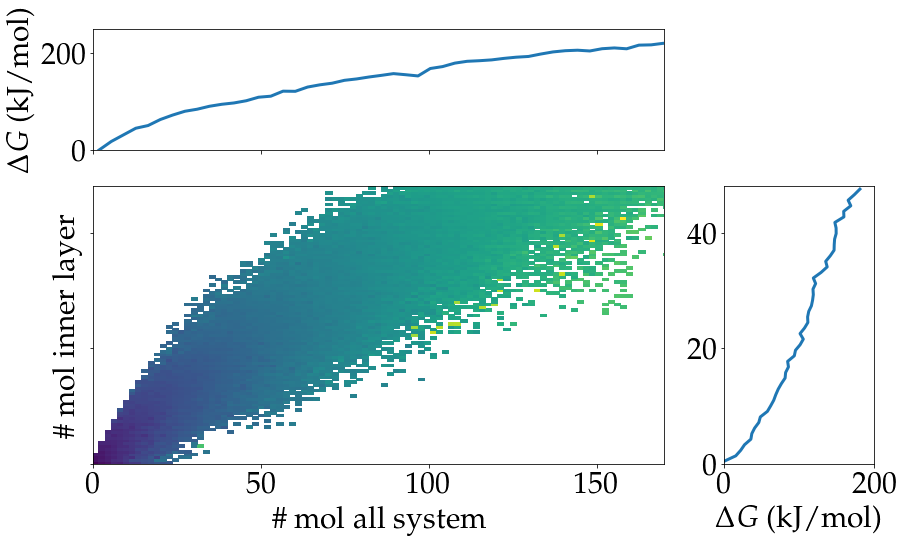

In [13]:
font = {'family' : 'serif',
        'serif'   : 'palatino',
        #'sans-serif'    : 'Computer Modern Sans serif',
        'style'   : 'normal',
        'variant'   : 'normal',
        'stretch'   : 'normal',
        'weight'   : 'normal',
        'size'   : 30}
plt.rc('font', **font)
plt.rc('text', usetex=True)
plt.rcParams['figure.figsize'] = (14,8) # The unit here is inches. 3.5 is good for one column, 7 is good for whole page


grid = plt.GridSpec(3, 4, wspace=0.4, hspace=0.3)
ax1 = plt.subplot(grid[0, :-1])
ax2 = plt.subplot(grid[1:, -1])
ax3 = plt.subplot(grid[1:, :-1])

temperature=270
beta=1./(0.00831441001626*temperature) # 1/(kJ/mol)
logweights=beta*bias
logweights -= np.amax(logweights)
H, xedges, yedges = np.histogram2d(cv4, cv5, bins=(100,100), density=True, weights=np.exp(logweights) )
H = H.T
fes = -(1./beta)*np.log(H)
X, Y = np.meshgrid(xedges, yedges)
cm = ax3.pcolormesh(X, Y, fes)
#plt.colorbar(cm, cax=ax4, orientation="horizontal", pad=0.5)

ax3.set_xlim([0,170])
ax3.set_ylim([0,48])
ax3.set_yticklabels([])
ax3.set_xlabel("\# mol all system")
ax3.set_ylabel("\# mol inner layer")

hist, bin_edges = np.histogram(cv4, weights=np.exp(logweights), density=True, bins=50) #,bins=65,range=(0,130))
freeEnergy=-(1./beta)*np.log(hist)
freeEnergy -= np.amin(freeEnergy[:5])
binCenters=(bin_edges[:-1]+bin_edges[1:])/2
ax1.plot(binCenters,freeEnergy,linewidth=3)
ax1.set_xlim([0,170])
ax1.set_ylim([0,250])
ax1.set_xticklabels([])
ax1.set_ylabel("$\Delta G$ (kJ/mol)")


hist, bin_edges = np.histogram(cv5, weights=np.exp(logweights), density=True, bins=50) #,bins=65,range=(0,130))
freeEnergy=-(1./beta)*np.log(hist)
freeEnergy -= np.amin(freeEnergy[:5])
binCenters=(bin_edges[:-1]+bin_edges[1:])/2
ax2.plot(freeEnergy,binCenters,linewidth=3)
ax2.set_ylim([0,48])
ax2.set_xlim([0,200])
ax2.set_xlabel("$\Delta G$ (kJ/mol)")

plt.show()

In [14]:
temperature=312
condition1=cv5 < 47.5
condition2=cv5 > 47.5
numBatches=4
deltaF, deltaFerror = freeEnergyWithErrorCondition(bias,temperature,condition1,condition2,numBatches)
print("Delta F",deltaF,"error",deltaFerror)
area=17.8506*23.1743
from_kJmol_to_Jm2=6.02214076/1000
num_surfaces=2
gamma=np.abs(deltaF)/(from_kJmol_to_Jm2*area*num_surfaces)
gamma_min=(np.abs(deltaF)-np.abs(deltaFerror))/(from_kJmol_to_Jm2*area*num_surfaces)
gamma_max=(np.abs(deltaF)+np.abs(deltaFerror))/(from_kJmol_to_Jm2*area*num_surfaces)
print("Interfacial free energy",gamma,"min",gamma_min,"max",gamma_max)

Delta F -184.2574751339911 error 2.026661731504165
Interfacial free energy 36.981521465955396 min 36.57475894913838 max 37.388283982772414


## pII

In [15]:
ignore=1*1000
COLVAR=np.genfromtxt("SecondaryPrismatic/COLVAR.0")[:-1,:]
final=COLVAR.shape[0]
print(final)
COLVAR = np.empty((4*(final-ignore),COLVAR.shape[1]))
COLVAR[0::4,:] = np.genfromtxt("SecondaryPrismatic/COLVAR.0")[ignore:final,:]
COLVAR[1::4,:] = np.genfromtxt("SecondaryPrismatic/COLVAR.1")[ignore:final,:]
COLVAR[2::4,:] = np.genfromtxt("SecondaryPrismatic/COLVAR.2")[ignore:final,:]
COLVAR[3::4,:] = np.genfromtxt("SecondaryPrismatic/COLVAR.3")[ignore:final,:]

199979


In [16]:
bias=np.copy(COLVAR[:,9]) +np.copy(COLVAR[:,17])+np.copy(COLVAR[:,19])+np.copy(COLVAR[:,22])
threshold=10
threshold2=300
choose=np.logical_and(np.logical_and(COLVAR[:,17]<threshold,COLVAR[:,19]<threshold),np.logical_and(COLVAR[:,9]<threshold2,COLVAR[:,22]<threshold))
cv1=np.copy(COLVAR[choose,4])
cv2=np.copy(COLVAR[choose,2])
cv3=np.copy(COLVAR[choose,6])
cv4=np.copy(COLVAR[choose,25])
cv5=np.copy(COLVAR[choose,27])
ene=np.copy(COLVAR[choose,7])
vol1=np.copy(COLVAR[choose,8])
bias=np.copy(COLVAR[choose,9]) +np.copy(COLVAR[choose,17])+np.copy(COLVAR[choose,19])+np.copy(COLVAR[choose,22])
print(bias.shape)

(736940,)


<ipython-input-17-d31a0685a972>:25: RuntimeWarning: divide by zero encountered in log
  fes = -(1./beta)*np.log(H)


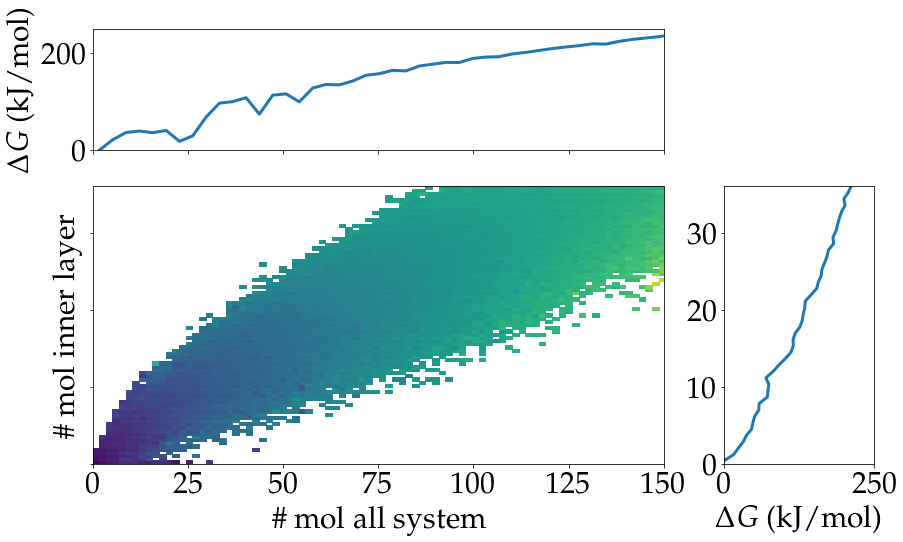

In [17]:
font = {'family' : 'serif',
        'serif'   : 'palatino',
        #'sans-serif'    : 'Computer Modern Sans serif',
        'style'   : 'normal',
        'variant'   : 'normal',
        'stretch'   : 'normal',
        'weight'   : 'normal',
        'size'   : 30}
plt.rc('font', **font)
plt.rc('text', usetex=True)
plt.rcParams['figure.figsize'] = (14,8) # The unit here is inches. 3.5 is good for one column, 7 is good for whole page


grid = plt.GridSpec(3, 4, wspace=0.4, hspace=0.3)
ax1 = plt.subplot(grid[0, :-1])
ax2 = plt.subplot(grid[1:, -1])
ax3 = plt.subplot(grid[1:, :-1])

temperature=312
beta=1./(0.00831441001626*temperature) # 1/(kJ/mol)
logweights=beta*bias
logweights -= np.amax(logweights)
H, xedges, yedges = np.histogram2d(cv4, cv5, bins=(100,100), density=True, weights=np.exp(logweights) )
H = H.T
fes = -(1./beta)*np.log(H)
X, Y = np.meshgrid(xedges, yedges)
cm = ax3.pcolormesh(X, Y, fes)
#plt.colorbar(cm, cax=ax4, orientation="horizontal", pad=0.5)

ax3.set_xlim([0,150])
ax3.set_ylim([0,36])
ax3.set_yticklabels([])
ax3.set_xlabel("\# mol all system")
ax3.set_ylabel("\# mol inner layer")

hist, bin_edges = np.histogram(cv4, weights=np.exp(logweights), density=True, bins=50) #,bins=65,range=(0,130))
freeEnergy=-(1./beta)*np.log(hist)
freeEnergy -= np.amin(freeEnergy[:5])
binCenters=(bin_edges[:-1]+bin_edges[1:])/2
ax1.plot(binCenters,freeEnergy,linewidth=3)
ax1.set_xlim([0,150])
ax1.set_ylim([0,250])
ax1.set_xticklabels([])
ax1.set_ylabel("$\Delta G$ (kJ/mol)")


hist, bin_edges = np.histogram(cv5, weights=np.exp(logweights), density=True, bins=50) #,bins=65,range=(0,130))
freeEnergy=-(1./beta)*np.log(hist)
freeEnergy -= np.amin(freeEnergy[:5])
binCenters=(bin_edges[:-1]+bin_edges[1:])/2
ax2.plot(freeEnergy,binCenters,linewidth=3)
ax2.set_ylim([0,36])
ax2.set_xlim([0,250])
ax2.set_xlabel("$\Delta G$ (kJ/mol)")

plt.show()

In [18]:
temperature=312
condition1=cv5 < 35.5
condition2=cv5 > 35.5
numBatches=4
deltaF, deltaFerror = freeEnergyWithErrorCondition(bias,temperature,condition1,condition2,numBatches)
print("Delta F",deltaF,"error",deltaFerror)
area=21.9326*23.1743
from_kJmol_to_Jm2=6.02214076/1000
num_surfaces=2
gamma=np.abs(deltaF)/(from_kJmol_to_Jm2*area*num_surfaces)
gamma_min=(np.abs(deltaF)-np.abs(deltaFerror))/(from_kJmol_to_Jm2*area*num_surfaces)
gamma_max=(np.abs(deltaF)+np.abs(deltaFerror))/(from_kJmol_to_Jm2*area*num_surfaces)
print("Interfacial free energy",gamma,"min",gamma_min,"max",gamma_max)

Delta F -210.52401943159055 error 0.43467510625794553
Interfacial free energy 34.389353563018425 min 34.318348857928214 max 34.46035826810864
